In [1]:
import pandas as pd
diabetes_dataset = "/Users/DYNAMIC-COMPUTER/Downloads/diabetes.csv"
diabetes = pd.read_csv(diabetes_dataset, encoding='utf-8')

In [2]:
X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']

X_train = X[0:613]
y_train = y[0:613]
X_valid = X[613:690]
y_valid = y[613:690]
X_test = X[690:760] 
y_test = y[690:760]

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)
model_predictions = model.predict(X_valid)
print('Accuracy Score', accuracy_score(model_predictions, y_valid))

Accuracy Score 0.7532467532467533


In [4]:
from sklearn.ensemble import RandomForestClassifier
model2 = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=250, max_leaf_nodes=16, n_jobs=-1, random_state=42)
)
model2.fit(X_train, y_train)
model2_predictions = model2.predict(X_valid)
print('Accuracy Score', accuracy_score(model2_predictions, y_valid))

Accuracy Score 0.7402597402597403


In [5]:
from skopt import BayesSearchCV
rf = RandomForestClassifier(random_state=42)
search_spaces = {
    'n_estimators' : (100, 500),
    'max_depth' : (3, 15),
    'min_samples_split' : (2, 10),
    'min_samples_leaf' : (1, 5),
}
bayes_search_rf = BayesSearchCV(
    estimator = rf,
    search_spaces = search_spaces,
    n_iter = 32,
    cv = 5,
    scoring = 'accuracy',
    random_state = 42,
    n_jobs = 1
)
bayes_search_rf.fit(X_train, y_train)

print('Best parameters:', bayes_search_rf.best_params_)
print('Best score:', bayes_search_rf.best_score_)

Best parameters: OrderedDict({'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 335})
Best score: 0.7815540450486471


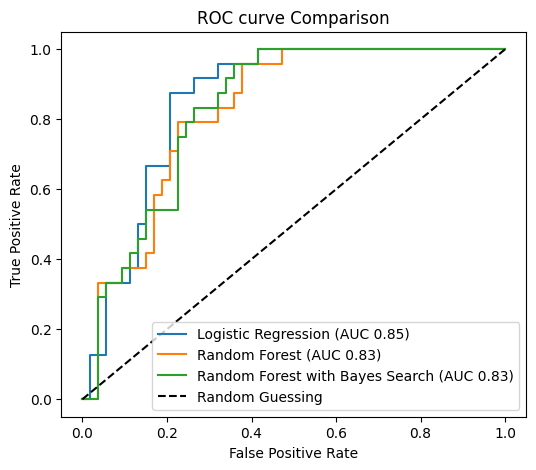

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

predict_proba_lr = model.predict_proba(X_valid)[:, 1]
predict_proba_rf = model2.predict_proba(X_valid)[:, 1]
predict_proba_rf_bayes = bayes_search_rf.predict_proba(X_valid)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_valid, predict_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, predict_proba_rf)
fpr_rf_bayes, tpr_rf_bayes, _ = roc_curve(y_valid, predict_proba_rf_bayes)

auc_lr = roc_auc_score(y_valid, predict_proba_lr)
auc_rf = roc_auc_score(y_valid, predict_proba_rf)
auc_rf_bayes = roc_auc_score(y_valid, predict_proba_rf_bayes)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC {auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC {auc_rf:.2f})')
plt.plot(fpr_rf_bayes, tpr_rf_bayes, label=f'Random Forest with Bayes Search (AUC {auc_rf_bayes:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Comparison')
plt.legend(loc='lower right')

plt.show()

In [7]:
y_test_pred = bayes_search_rf.predict(X_test)
y_test_proba = bayes_search_rf.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Final Test Accuracy: {test_accuracy:.2f}")
print(f"Final Test AUC: {test_auc:.2f}")

Final Test Accuracy: 0.79
Final Test AUC: 0.85
